## learning rate effect
如果 Learning rate (LR, alpha) 太⼤，將會導致每步更新時，無法在陡峭的損失⼭⾕中，順利的往下滑動；但若太⼩，則要滑到⾕底的時間過於冗長，且若遇到平原區則無法找到正確的⽅向。
<img src="imgs/keras10_LR effect.png" width="90%">

## [Learning rates and Optimizers](http://cs231n.github.io/neural-networks-3/)

### SGD (mini-batch)
- 在單步更新與全局更新的折衷辦法，通常搭配 momentum 穩定收斂⽅向與結果。
- 收斂速度較慢。

### RMSprop
- 學習率的調整是根據過去梯度的狀況調整，收斂速度快⼜不易會出現learning rate 快速下降的狀況。

### Adam
- 同樣是可以根據過去的梯度⾃⾏調整 learning rate，但校正⽅式考量⼀、⼆階矩陣，使其更加平穩。

#### 在實作過程中，建議先使⽤ Adam 驗證，若要做最終的優化，則再改⽤ SGD 找到最佳參數。

<img src="imgs/keras10_optimizers.gif" width="80%">

In [1]:
import os
from tensorflow import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

In [12]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.100000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

50000/50000 [==============================] - 8s 158us/sample - loss: 1.4661 - accuracy: 0.4839 - val_loss: 1.6607 - val_accuracy: 0.4343
Epoch 49/50
50000/50000 [==============================] - 9s 178us/sample - loss: 1.4720 - accuracy: 0.4824 - val_loss: 1.7283 - val_accuracy: 0.4075
Epoch 50/50
50000/50000 [==============================] - 8s 169us/sample - loss: 1.4734 - accuracy: 0.4824 - val_loss: 1.7387 - val_accuracy: 0.4101
Experiment with LR = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
____________________________________________________

50000/50000 [==============================] - 20s 400us/sample - loss: 0.4370 - accuracy: 0.8426 - val_loss: 2.0013 - val_accuracy: 0.5340
Epoch 46/50
50000/50000 [==============================] - 20s 402us/sample - loss: 0.4273 - accuracy: 0.8460 - val_loss: 2.0481 - val_accuracy: 0.5178
Epoch 47/50
50000/50000 [==============================] - 21s 410us/sample - loss: 0.4283 - accuracy: 0.8467 - val_loss: 2.1251 - val_accuracy: 0.5202
Epoch 48/50
50000/50000 [==============================] - 21s 410us/sample - loss: 0.4115 - accuracy: 0.8530 - val_loss: 2.1692 - val_accuracy: 0.5161
Epoch 49/50
50000/50000 [==============================] - 20s 402us/sample - loss: 0.4107 - accuracy: 0.8530 - val_loss: 2.2053 - val_accuracy: 0.5251
Epoch 50/50
50000/50000 [==============================] - 21s 415us/sample - loss: 0.3938 - accuracy: 0.8594 - val_loss: 2.3235 - val_accuracy: 0.5126
Experiment with LR = 0.001000
Model: "model"
_______________________________________________________

50000/50000 [==============================] - 14s 276us/sample - loss: 0.9716 - accuracy: 0.6583 - val_loss: 1.3893 - val_accuracy: 0.5267
Epoch 42/50
50000/50000 [==============================] - 14s 272us/sample - loss: 0.9584 - accuracy: 0.6632 - val_loss: 1.3508 - val_accuracy: 0.5361
Epoch 43/50
50000/50000 [==============================] - 13s 268us/sample - loss: 0.9441 - accuracy: 0.6679 - val_loss: 1.4224 - val_accuracy: 0.5215
Epoch 44/50
50000/50000 [==============================] - 14s 271us/sample - loss: 0.9383 - accuracy: 0.6704 - val_loss: 1.4095 - val_accuracy: 0.5207
Epoch 45/50
50000/50000 [==============================] - 14s 276us/sample - loss: 0.9206 - accuracy: 0.6768 - val_loss: 1.3750 - val_accuracy: 0.5270
Epoch 46/50
50000/50000 [==============================] - 14s 271us/sample - loss: 0.9111 - accuracy: 0.6816 - val_loss: 1.3976 - val_accuracy: 0.5279
Epoch 47/50
50000/50000 [==============================] - 13s 269us/sample - loss: 0.9048 - accurac

50000/50000 [==============================] - 13s 266us/sample - loss: 1.6143 - accuracy: 0.4383 - val_loss: 1.6255 - val_accuracy: 0.4296
Epoch 38/50
50000/50000 [==============================] - 13s 269us/sample - loss: 1.6093 - accuracy: 0.4389 - val_loss: 1.6199 - val_accuracy: 0.4338
Epoch 39/50
50000/50000 [==============================] - 14s 272us/sample - loss: 1.6043 - accuracy: 0.4417 - val_loss: 1.6175 - val_accuracy: 0.4346
Epoch 40/50
50000/50000 [==============================] - 13s 266us/sample - loss: 1.5995 - accuracy: 0.4429 - val_loss: 1.6124 - val_accuracy: 0.4368
Epoch 41/50
50000/50000 [==============================] - 14s 277us/sample - loss: 1.5947 - accuracy: 0.4442 - val_loss: 1.6076 - val_accuracy: 0.4374
Epoch 42/50
50000/50000 [==============================] - 13s 268us/sample - loss: 1.5896 - accuracy: 0.4471 - val_loss: 1.6051 - val_accuracy: 0.4346
Epoch 43/50
50000/50000 [==============================] - 14s 273us/sample - loss: 1.5854 - accurac

50000/50000 [==============================] - 15s 303us/sample - loss: 1.9795 - accuracy: 0.3106 - val_loss: 1.9792 - val_accuracy: 0.3149
Epoch 34/50
50000/50000 [==============================] - 14s 277us/sample - loss: 1.9743 - accuracy: 0.3122 - val_loss: 1.9741 - val_accuracy: 0.3169
Epoch 35/50
50000/50000 [==============================] - 14s 285us/sample - loss: 1.9694 - accuracy: 0.3146 - val_loss: 1.9693 - val_accuracy: 0.3174
Epoch 36/50
50000/50000 [==============================] - 14s 285us/sample - loss: 1.9646 - accuracy: 0.3157 - val_loss: 1.9646 - val_accuracy: 0.3199
Epoch 37/50
50000/50000 [==============================] - 14s 288us/sample - loss: 1.9600 - accuracy: 0.3183 - val_loss: 1.9601 - val_accuracy: 0.3182
Epoch 38/50
50000/50000 [==============================] - 14s 285us/sample - loss: 1.9555 - accuracy: 0.3185 - val_loss: 1.9556 - val_accuracy: 0.3220
Epoch 39/50
50000/50000 [==============================] - 14s 288us/sample - loss: 1.9512 - accurac

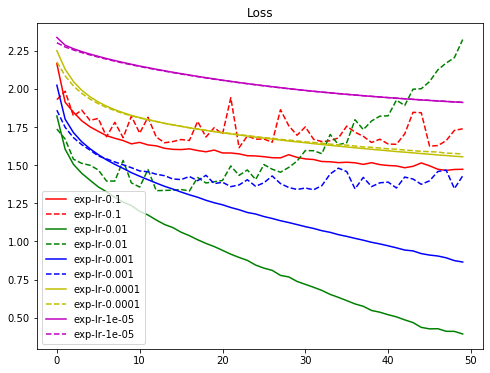

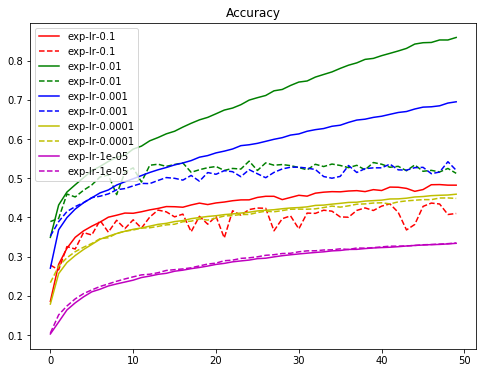

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [33]:
## 超參數設定
LEARNING_RATE = [1e-2, 1e-3,1e-4]
EPOCHS = 150
BATCH_SIZE = 256
MOMENTUM = 0.95

In [ ]:
results1= {}
results2= {}
results3= {}
RESULTS=[results1,results2,results3]
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr, results in zip(LEARNING_RATE,RESULTS):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    sgd = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    rmsprop = keras.optimizers.RMSprop(lr=lr)
    adam = keras.optimizers.Adam(lr=lr)
    OPTIMIZER = [sgd, rmsprop, adam]
    OPTIMIZER_NAME =['sgd','rmsprop','adam']
    for optimizer,NAME in zip(OPTIMIZER,OPTIMIZER_NAME):
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
    
        name_tag = "optimizer=%s" %NAME
        results[name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 9s 186us

Epoch 48/150
50000/50000 [==============================] - 7s 147us/sample - loss: 0.4109 - accuracy: 0.8516 - val_loss: 2.1633 - val_accuracy: 0.5276
Epoch 49/150
50000/50000 [==============================] - 7s 147us/sample - loss: 0.3839 - accuracy: 0.8609 - val_loss: 2.2872 - val_accuracy: 0.5270
Epoch 50/150
50000/50000 [==============================] - 7s 146us/sample - loss: 0.3674 - accuracy: 0.8683 - val_loss: 2.3379 - val_accuracy: 0.5252
Epoch 51/150
50000/50000 [==============================] - 7s 149us/sample - loss: 0.3542 - accuracy: 0.8726 - val_loss: 2.4604 - val_accuracy: 0.5178
Epoch 52/150
50000/50000 [==============================] - 7s 148us/sample - loss: 0.3521 - accuracy: 0.8718 - val_loss: 2.6139 - val_accuracy: 0.5096
Epoch 53/150
50000/50000 [==============================] - 8s 150us/sample - loss: 0.3438 - accuracy: 0.8763 - val_loss: 2.4090 - val_accuracy: 0.5304
Epoch 54/150
50000/50000 [==============================] - 8s 151us/sample - loss: 0.32

Epoch 102/150
50000/50000 [==============================] - 7s 150us/sample - loss: 0.1439 - accuracy: 0.9493 - val_loss: 4.1617 - val_accuracy: 0.5248
Epoch 103/150
50000/50000 [==============================] - 7s 147us/sample - loss: 0.1563 - accuracy: 0.9453 - val_loss: 4.0643 - val_accuracy: 0.5198
Epoch 104/150
50000/50000 [==============================] - 7s 146us/sample - loss: 0.1512 - accuracy: 0.9472 - val_loss: 4.2330 - val_accuracy: 0.5317
Epoch 105/150
50000/50000 [==============================] - 8s 153us/sample - loss: 0.1570 - accuracy: 0.9453 - val_loss: 4.1701 - val_accuracy: 0.5245
Epoch 106/150
50000/50000 [==============================] - 8s 158us/sample - loss: 0.1491 - accuracy: 0.9481 - val_loss: 4.1762 - val_accuracy: 0.5174
Epoch 107/150
50000/50000 [==============================] - 8s 151us/sample - loss: 0.1466 - accuracy: 0.9491 - val_loss: 4.1950 - val_accuracy: 0.5246
Epoch 108/150
50000/50000 [==============================] - 7s 147us/sample - los

50000/50000 [==============================] - 13s 258us/sample - loss: 2.3031 - accuracy: 0.0992 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 6/150
50000/50000 [==============================] - 11s 219us/sample - loss: 2.3031 - accuracy: 0.0996 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 7/150
50000/50000 [==============================] - 11s 222us/sample - loss: 2.3032 - accuracy: 0.1002 - val_loss: 2.3033 - val_accuracy: 0.1000
Epoch 8/150
50000/50000 [==============================] - 11s 223us/sample - loss: 2.3031 - accuracy: 0.0998 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 9/150
50000/50000 [==============================] - 12s 235us/sample - loss: 2.3032 - accuracy: 0.0971 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 10/150
50000/50000 [==============================] - 11s 226us/sample - loss: 2.3031 - accuracy: 0.0990 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 11/150
50000/50000 [==============================] - 12s 242us/sample - loss: 2.3030 - accur

50000/50000 [==============================] - 11s 214us/sample - loss: 2.3032 - accuracy: 0.0981 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 59/150
50000/50000 [==============================] - 11s 216us/sample - loss: 2.3032 - accuracy: 0.1011 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 60/150
50000/50000 [==============================] - 11s 214us/sample - loss: 2.3030 - accuracy: 0.1014 - val_loss: 2.3035 - val_accuracy: 0.1000
Epoch 61/150
50000/50000 [==============================] - 11s 221us/sample - loss: 2.3032 - accuracy: 0.1007 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 62/150
50000/50000 [==============================] - 11s 215us/sample - loss: 2.3031 - accuracy: 0.0990 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 63/150
50000/50000 [==============================] - 11s 217us/sample - loss: 2.3032 - accuracy: 0.0981 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 64/150
50000/50000 [==============================] - 11s 216us/sample - loss: 2.3033 - a

50000/50000 [==============================] - 11s 215us/sample - loss: 2.3031 - accuracy: 0.0986 - val_loss: 2.3032 - val_accuracy: 0.1000
Epoch 112/150
50000/50000 [==============================] - 11s 220us/sample - loss: 2.3031 - accuracy: 0.0986 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 113/150
50000/50000 [==============================] - 11s 216us/sample - loss: 2.3031 - accuracy: 0.1002 - val_loss: 2.3032 - val_accuracy: 0.1000
Epoch 114/150
50000/50000 [==============================] - 11s 217us/sample - loss: 2.3032 - accuracy: 0.0984 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 115/150
50000/50000 [==============================] - 11s 217us/sample - loss: 2.3031 - accuracy: 0.0981 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 116/150
50000/50000 [==============================] - 11s 216us/sample - loss: 2.3031 - accuracy: 0.1001 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 117/150
50000/50000 [==============================] - 11s 219us/sample - loss: 2.30

50000/50000 [==============================] - 8s 161us/sample - loss: 2.3032 - accuracy: 0.1001 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 15/150
50000/50000 [==============================] - 8s 161us/sample - loss: 2.3032 - accuracy: 0.0990 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 16/150
50000/50000 [==============================] - 8s 161us/sample - loss: 2.3030 - accuracy: 0.1011 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 17/150
50000/50000 [==============================] - 8s 162us/sample - loss: 2.3032 - accuracy: 0.0966 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 18/150
50000/50000 [==============================] - 8s 158us/sample - loss: 2.3031 - accuracy: 0.1004 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 19/150
50000/50000 [==============================] - 8s 161us/sample - loss: 2.3032 - accuracy: 0.0991 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 20/150
50000/50000 [==============================] - 8s 161us/sample - loss: 2.3030 - accuracy

Epoch 68/150
50000/50000 [==============================] - 8s 158us/sample - loss: 2.3031 - accuracy: 0.0994 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 69/150
50000/50000 [==============================] - 8s 165us/sample - loss: 2.3032 - accuracy: 0.0973 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 70/150
50000/50000 [==============================] - 8s 162us/sample - loss: 2.3031 - accuracy: 0.0981 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 71/150
50000/50000 [==============================] - 8s 158us/sample - loss: 2.3031 - accuracy: 0.0980 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 72/150
50000/50000 [==============================] - 8s 162us/sample - loss: 2.3030 - accuracy: 0.0986 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 73/150
50000/50000 [==============================] - 8s 161us/sample - loss: 2.3032 - accuracy: 0.0995 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 74/150
50000/50000 [==============================] - 8s 162us/sample - loss: 2.30

Epoch 122/150
50000/50000 [==============================] - 8s 158us/sample - loss: 2.3032 - accuracy: 0.0984 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 123/150
50000/50000 [==============================] - 5024s 100ms/sample - loss: 2.3031 - accuracy: 0.1005 - val_loss: 2.3033 - val_accuracy: 0.1000
Epoch 124/150
50000/50000 [==============================] - 21s 414us/sample - loss: 2.3032 - accuracy: 0.0972 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 125/150
50000/50000 [==============================] - 17s 334us/sample - loss: 2.3032 - accuracy: 0.0998 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 126/150
50000/50000 [==============================] - 18s 352us/sample - loss: 2.3032 - accuracy: 0.0974 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 127/150
50000/50000 [==============================] - 10s 200us/sample - loss: 2.3031 - accuracy: 0.0969 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 128/150
50000/50000 [==============================] - 8s 160us/sampl

Epoch 19/150
50000/50000 [==============================] - 8s 165us/sample - loss: 1.2770 - accuracy: 0.5511 - val_loss: 1.3838 - val_accuracy: 0.5085
Epoch 20/150
50000/50000 [==============================] - 8s 170us/sample - loss: 1.2613 - accuracy: 0.5572 - val_loss: 1.3804 - val_accuracy: 0.5123
Epoch 21/150
50000/50000 [==============================] - 8s 163us/sample - loss: 1.2445 - accuracy: 0.5656 - val_loss: 1.4054 - val_accuracy: 0.5049
Epoch 22/150
50000/50000 [==============================] - 8s 167us/sample - loss: 1.2307 - accuracy: 0.5681 - val_loss: 1.3776 - val_accuracy: 0.5158
Epoch 23/150
50000/50000 [==============================] - 8s 164us/sample - loss: 1.2141 - accuracy: 0.5738 - val_loss: 1.3504 - val_accuracy: 0.5209
Epoch 24/150
50000/50000 [==============================] - 8s 166us/sample - loss: 1.1984 - accuracy: 0.5802 - val_loss: 1.3641 - val_accuracy: 0.5166
Epoch 25/150
50000/50000 [==============================] - 8s 165us/sample - loss: 1.18

Epoch 73/150
50000/50000 [==============================] - 8s 167us/sample - loss: 0.6065 - accuracy: 0.7908 - val_loss: 1.5794 - val_accuracy: 0.5363
Epoch 74/150
50000/50000 [==============================] - 8s 165us/sample - loss: 0.6031 - accuracy: 0.7886 - val_loss: 1.5960 - val_accuracy: 0.5263
Epoch 75/150
50000/50000 [==============================] - 8s 158us/sample - loss: 0.5866 - accuracy: 0.7963 - val_loss: 1.7330 - val_accuracy: 0.5052
Epoch 76/150
50000/50000 [==============================] - 8s 158us/sample - loss: 0.5789 - accuracy: 0.8005 - val_loss: 1.6373 - val_accuracy: 0.5189
Epoch 77/150
50000/50000 [==============================] - 8s 160us/sample - loss: 0.5689 - accuracy: 0.8044 - val_loss: 1.6341 - val_accuracy: 0.5272
Epoch 78/150
50000/50000 [==============================] - 8s 159us/sample - loss: 0.5609 - accuracy: 0.8076 - val_loss: 1.6640 - val_accuracy: 0.5133
Epoch 79/150
50000/50000 [==============================] - 8s 158us/sample - loss: 0.55

Epoch 127/150
50000/50000 [==============================] - 8s 161us/sample - loss: 0.2023 - accuracy: 0.9360 - val_loss: 2.4739 - val_accuracy: 0.5244
Epoch 128/150
50000/50000 [==============================] - 8s 159us/sample - loss: 0.1881 - accuracy: 0.9401 - val_loss: 2.4192 - val_accuracy: 0.5266
Epoch 129/150
50000/50000 [==============================] - 8s 159us/sample - loss: 0.1721 - accuracy: 0.9475 - val_loss: 2.4898 - val_accuracy: 0.5254
Epoch 130/150
50000/50000 [==============================] - 8s 157us/sample - loss: 0.1860 - accuracy: 0.9409 - val_loss: 2.6208 - val_accuracy: 0.5108
Epoch 131/150
50000/50000 [==============================] - 8s 159us/sample - loss: 0.1882 - accuracy: 0.9400 - val_loss: 2.5717 - val_accuracy: 0.5202
Epoch 132/150
50000/50000 [==============================] - 8s 160us/sample - loss: 0.1506 - accuracy: 0.9552 - val_loss: 2.5013 - val_accuracy: 0.5318
Epoch 133/150
50000/50000 [==============================] - 8s 157us/sample - los

50000/50000 [==============================] - 11s 227us/sample - loss: 1.1082 - accuracy: 0.6030 - val_loss: 1.6082 - val_accuracy: 0.4911
Epoch 31/150
50000/50000 [==============================] - 11s 225us/sample - loss: 1.0967 - accuracy: 0.6131 - val_loss: 1.8682 - val_accuracy: 0.4627
Epoch 32/150
50000/50000 [==============================] - 11s 229us/sample - loss: 1.0803 - accuracy: 0.6184 - val_loss: 2.0628 - val_accuracy: 0.4169
Epoch 33/150
50000/50000 [==============================] - 11s 228us/sample - loss: 1.0722 - accuracy: 0.6188 - val_loss: 1.8922 - val_accuracy: 0.4401
Epoch 34/150
50000/50000 [==============================] - 11s 225us/sample - loss: 1.0574 - accuracy: 0.6256 - val_loss: 1.7066 - val_accuracy: 0.5010
Epoch 35/150
50000/50000 [==============================] - 11s 227us/sample - loss: 1.0412 - accuracy: 0.6314 - val_loss: 1.7008 - val_accuracy: 0.4920
Epoch 36/150
50000/50000 [==============================] - 11s 227us/sample - loss: 1.0262 - a

50000/50000 [==============================] - 11s 227us/sample - loss: 0.6531 - accuracy: 0.7731 - val_loss: 3.1510 - val_accuracy: 0.4758
Epoch 84/150
50000/50000 [==============================] - 11s 225us/sample - loss: 0.6447 - accuracy: 0.7733 - val_loss: 3.1224 - val_accuracy: 0.4774
Epoch 85/150
50000/50000 [==============================] - 11s 225us/sample - loss: 0.6356 - accuracy: 0.7782 - val_loss: 2.8908 - val_accuracy: 0.4895
Epoch 86/150
50000/50000 [==============================] - 11s 226us/sample - loss: 0.6299 - accuracy: 0.7780 - val_loss: 3.8812 - val_accuracy: 0.4659
Epoch 87/150
50000/50000 [==============================] - 11s 226us/sample - loss: 0.6251 - accuracy: 0.7826 - val_loss: 3.2878 - val_accuracy: 0.4653
Epoch 88/150
50000/50000 [==============================] - 11s 228us/sample - loss: 0.6181 - accuracy: 0.7812 - val_loss: 2.9973 - val_accuracy: 0.4825
Epoch 89/150
50000/50000 [==============================] - 11s 227us/sample - loss: 0.6188 - a

50000/50000 [==============================] - 13s 258us/sample - loss: 0.4756 - accuracy: 0.8376 - val_loss: 4.6553 - val_accuracy: 0.4885
Epoch 137/150
50000/50000 [==============================] - 13s 262us/sample - loss: 0.4714 - accuracy: 0.8380 - val_loss: 5.0100 - val_accuracy: 0.4649
Epoch 138/150
50000/50000 [==============================] - 13s 255us/sample - loss: 0.4691 - accuracy: 0.8400 - val_loss: 4.9257 - val_accuracy: 0.4725
Epoch 139/150
50000/50000 [==============================] - 13s 253us/sample - loss: 0.4609 - accuracy: 0.8387 - val_loss: 4.3862 - val_accuracy: 0.4921
Epoch 140/150
50000/50000 [==============================] - 12s 246us/sample - loss: 0.4583 - accuracy: 0.8418 - val_loss: 5.2091 - val_accuracy: 0.4691
Epoch 141/150
50000/50000 [==============================] - 12s 248us/sample - loss: 0.4521 - accuracy: 0.8446 - val_loss: 4.6910 - val_accuracy: 0.4847
Epoch 142/150
50000/50000 [==============================] - 12s 249us/sample - loss: 0.45

50000/50000 [==============================] - 10s 190us/sample - loss: 0.2748 - accuracy: 0.9036 - val_loss: 5.0945 - val_accuracy: 0.5079
Epoch 40/150
50000/50000 [==============================] - 10s 192us/sample - loss: 0.2572 - accuracy: 0.9081 - val_loss: 4.9123 - val_accuracy: 0.4994
Epoch 41/150
50000/50000 [==============================] - 10s 197us/sample - loss: 0.2225 - accuracy: 0.9218 - val_loss: 5.1187 - val_accuracy: 0.5010
Epoch 42/150
50000/50000 [==============================] - 10s 193us/sample - loss: 0.2476 - accuracy: 0.9117 - val_loss: 5.0408 - val_accuracy: 0.5042
Epoch 43/150
50000/50000 [==============================] - 10s 196us/sample - loss: 0.2522 - accuracy: 0.9113 - val_loss: 5.2722 - val_accuracy: 0.4998
Epoch 44/150
50000/50000 [==============================] - 9s 190us/sample - loss: 0.2983 - accuracy: 0.8976 - val_loss: 4.8469 - val_accuracy: 0.4996
Epoch 45/150
50000/50000 [==============================] - 10s 193us/sample - loss: 0.2801 - ac

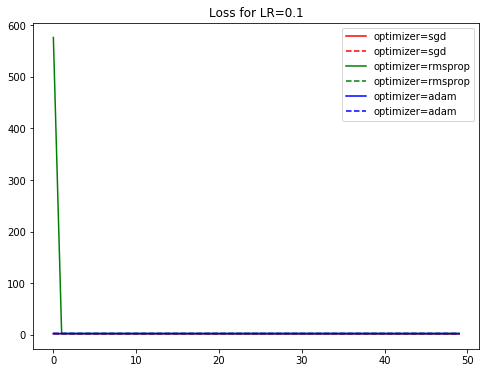

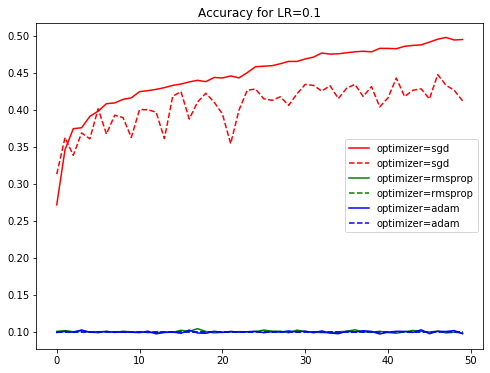

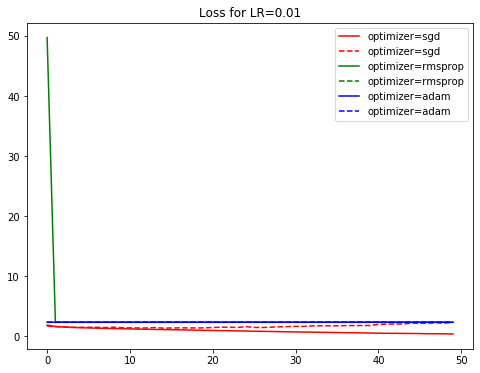

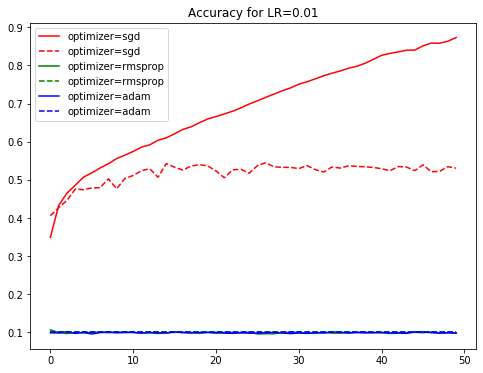

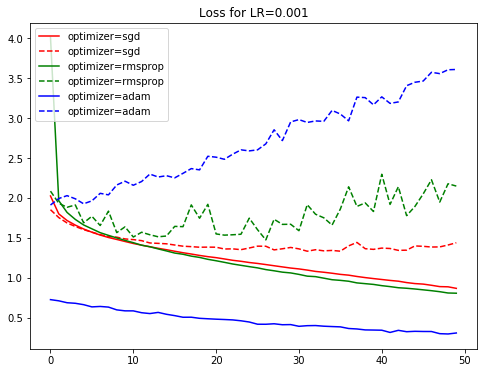

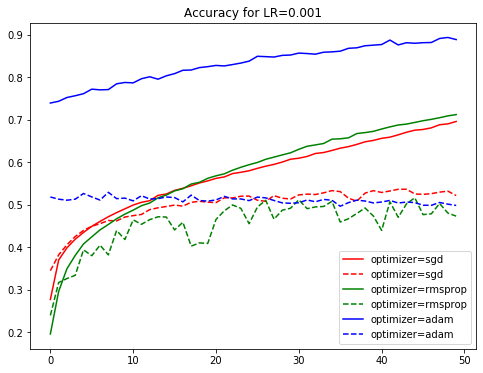

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b"]
TITLE=["LR=0.1","LR=0.01","LR=0.001"]
for results,title in zip(RESULTS,TITLE):
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss for "+title)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results1.keys()):
        plt.plot(range(len(results1[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results1[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy for "+title)
    plt.legend()
    plt.show()

